In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from fastai import *
from fastai.vision import *
import json,os,gc
from utils import *

In [4]:
torch.backends.cudnn.benchmark =True

In [5]:
NUM_SAMPLES_PER_CLASS = 40_000
NUM_VAL = 50 * 800

In [6]:
PATH = Path('data/txt')

In [7]:
torch.cuda.device_count()

2

### Generate data from csvs

###  Create ImageDataBunch using the data block API

In [8]:
sz = 128
bs = 2700

In [9]:
def cf(path):
    with open(path) as f: j = json.load(f)
    dr = list2drawing(j['drawing'],size=sz,time_color=True)
    return Image(drawing2tensor(dr).div_(255))



In [10]:

item_list = ItemList.from_folder(PATH/'train/', create_func=cf)
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]

In [11]:
item_lists = item_list.split_by_idx(val_idxs)
label_lists = item_lists.label_from_folder()

In [32]:
tff = get_transforms(max_lighting=0.0,max_zoom=1.2)

In [34]:
label_lists = label_lists.transform([tff,tff])

In [35]:
test_items = ItemList.from_folder(PATH/'test', create_func=cf)
label_lists.add_test(test_items);

train_dl = DataLoader(label_lists.train, bs, True, num_workers=26)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=6)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl,tfms=tff);
data_bunch.normalize(data_bunch.batch_stats());

AttributeError: 'list' object has no attribute 'tfm'

In [15]:
ImageDataBunch??

In [20]:
pd.to_pickle(data_bunch.batch_stats(), f'data/batch_stats_{sz}.pkl')

# batch_stats = pd.read_pickle(f'data/batch_stats_{sz}.pkl')

# data_bunch.normalize(batch_stats);

In [51]:
def get_data_bunch(label_lists,bs,n_w=[26,10,8]):
    train_dl = DataLoader(label_lists.train, bs, True, num_workers=n_w[0])
    valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=n_w[0])
    test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=n_w[0])
    data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)
    data_bunch.normalize(data_bunch.batch_stats());
    return data_bunch

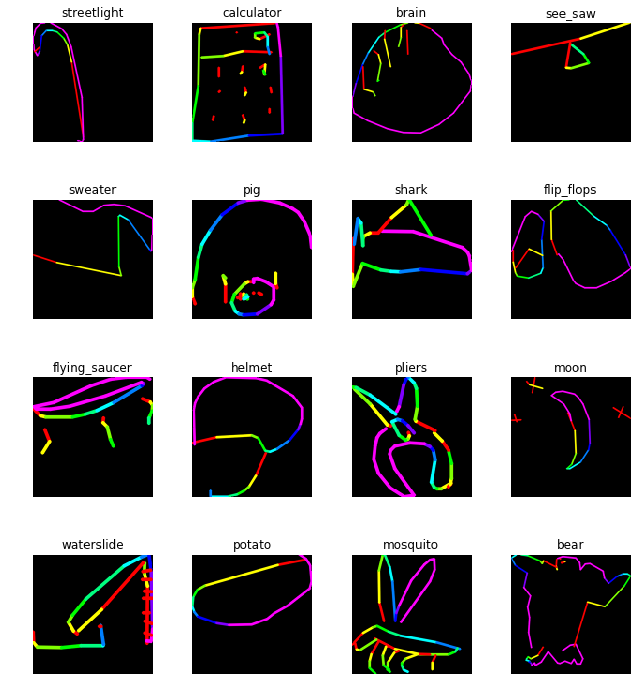

In [13]:
data_bunch.show_batch(rows=4) #128

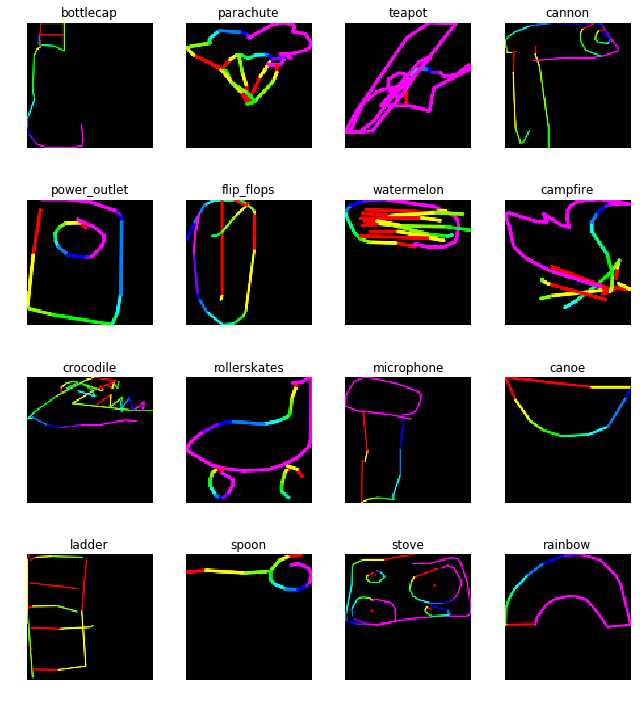

In [15]:
data_bunch.show_batch(rows=4)

### Train

In [42]:
name = f'res34-{sz}-2p100'

In [14]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [15]:
name

'res34-128-2p100'

In [22]:
torch.cuda.device_count()

2

In [16]:
learn.model = nn.DataParallel(learn.model)

In [17]:
sz

128

In [25]:
learn.freeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


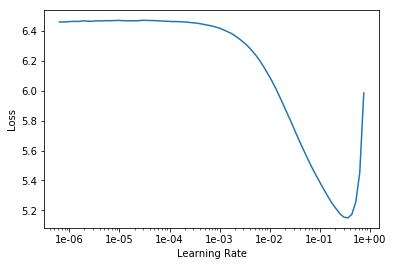

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(1,2.5e-2)

Total time: 45:40
epoch  train_loss  valid_loss  accuracy  map3    
1      1.435712    1.248418    0.689225  0.764742  (45:40)



In [38]:
name

'res34-64-2p100'

In [39]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-1-0212.pth')

In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


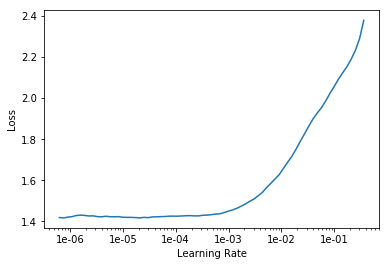

In [42]:
learn.recorder.plot()

In [43]:
learn.freeze()

In [44]:
learn.fit_one_cycle(1,2.5e-2)

Total time: 29:07
epoch  train_loss  valid_loss  accuracy  map3    
1      1.422358    1.227530    0.693800  0.768842  (29:07)



In [45]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-2-0212.pth')

In [55]:
learn.model.module.load_state_dict(torch.load(f'models/{name}-stage-2-0212.pth'))

In [56]:
learn.unfreeze()

In [54]:
learn.data = get_data_bunch(label_lists,int(bs*3.4),[30,8,8])

In [57]:
learn.fit_one_cycle(2,slice(5e-5,4e-4))

Total time: 1:11:49
epoch  train_loss  valid_loss  accuracy  map3    
1      1.094386    0.986318    0.749075  0.815825  (36:11)
2      0.992156    0.908421    0.769225  0.831079  (35:38)



In [58]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-2-0212.pth') ##mistakeknly saved for same name

In [ ]:
gc.collect()

In [67]:
def get_diff_sz_data_bunch(sze,bs,n_w=[30,8,8]):
    global sz
    sz = int(sze)
    item_list = ItemList.from_folder(PATH/'train/', create_func=cf)
    idxs = np.arange(item_list.items.shape[0])
    np.random.shuffle(idxs)
    val_idxs = idxs[:NUM_VAL]
    item_lists = item_list.split_by_idx(val_idxs)
    label_lists = item_lists.label_from_folder()
    test_items = ItemList.from_folder(PATH/'test', create_func=cf)
    label_lists.add_test(test_items);

    train_dl = DataLoader(label_lists.train, bs, True, num_workers=n_w[0])
    valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=n_w[1])
    test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=n_w[2])

    data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)
    data_bunch.normalize(data_bunch.batch_stats());
    return data_bunch

In [70]:
learn.data = get_diff_sz_data_bunch(64,int(bs*1.3))

In [71]:
learn.unfreeze()

In [72]:
learn.model.module.load_state_dict(torch.load(f'models/{name}-stage-2-0212.pth'))

In [73]:
learn.fit_one_cycle(2,slice(6e-5,4.3e-4))

Total time: 1:13:56
epoch  train_loss  valid_loss  accuracy  map3    
1      0.972484    0.904556    0.768950  0.831825  (36:59)
2      0.876884    0.826390    0.788950  0.847129  (36:56)



In [74]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-3-0212.pth')

In [75]:
learn.fit_one_cycle(2,slice(6e-5,4.3e-4))

Total time: 1:13:58
epoch  train_loss  valid_loss  accuracy  map3    
1      0.898724    0.853114    0.783250  0.843071  (37:00)
2      0.817918    0.795439    0.797725  0.854150  (36:57)



In [76]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-4-0212.pth')

In [78]:
learn.fit_one_cycle(1,slice(1e-5,3e-4))

Total time: 36:58
epoch  train_loss  valid_loss  accuracy  map3    
1      0.795640    0.790244    0.798950  0.855204  (36:58)



In [79]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-5-0212.pth')

In [83]:
learn.model.module.load_state_dict(torch.load(f'models/{name}-stage-5-0212.pth'))

In [84]:
learn.data = get_diff_sz_data_bunch(96,int(bs*2.5))

In [85]:
gc.collect()

0

In [86]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


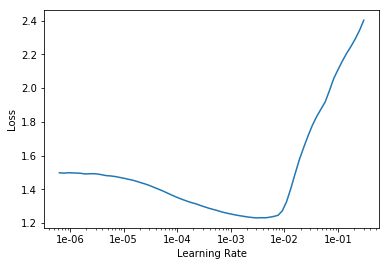

In [87]:
learn.recorder.plot()

In [88]:
learn.fit_one_cycle(1,slice(5e-5,9e-4))

epoch,train_loss,valid_loss,accuracy,map3


RuntimeError: DataLoader worker (pid 2772) is killed by signal: Bus error. 

In [90]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-6-0212.pth') #0.805 loss;83%complete

In [24]:
!ls ./models/

above905-res50-196-2v100-stage-1-196.pth  res34-64-2p100-stage-2-0212.pth
above905-res50-196-2v100-stage-2-196.pth  res34-64-2p100-stage-3-0212.pth
above905-res50-196-2v100-stage-3-196.pth  res34-64-2p100-stage-4-0212.pth
above905-res50-196-2v100-stage-4-196.pth  res34-64-2p100-stage-5-0212.pth
above905-res50-196-2v100-stage-5-196.pth  res34-64-2p100-stage-6-0212.pth
above905-res50-196-2v100-stage-6-196.pth  res50-128-2-stage-10-128.pth
mb-mb-res50-128-2-stage-1-128.pth	  res50-128-44-stage-1-128.pth
mb-mb-res50-128-2-stage-2-128.pth	  res50-128-44-stage-2-128.pth
mb-mb-res50-128-4-stage-1-128.pth	  res50-128-44-stage-3-128.pth
mb-mb-res50-128-4-stage-2-128.pth	  res50-224-8-stage-4-224.pth
mb-mb-res50-128-4-stage-3-128.pth	  res50-224-8-stage-5-224.pth
mb-mb-res50-128-4-stage-4-128.pth	  res50-224-stage--224
mb-mb-res50-128-4-stage-5-128.pth	  res50-224-stage-3-224.pth
mb-mb-res50-128-4-stage-6-128.pth	  res50-64-4-stage-1-64.pth
mb-mb-res50-64-2-stage-1-128.pth	  res50-64-4-stage-2-6

In [25]:
learn.model.module.load_state_dict(torch.load(f'models/res34-64-2p100-stage-6-0212.pth'))

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1,slice(2e-5,3e-4))

Total time: 1:07:26
epoch  train_loss  valid_loss  accuracy  map3    
1      0.772516    0.727815    0.810900  0.864546  (1:07:26)



In [28]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-1-0312.pth')

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


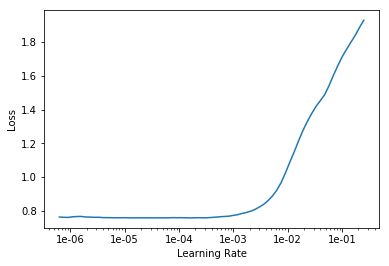

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(2,slice(6e-6,3e-4))

Total time: 2:14:57
epoch  train_loss  valid_loss  accuracy  map3    
1      0.763196    0.730225    0.809775  0.863937  (1:07:23)
2      0.743370    0.720244    0.812775  0.866000  (1:07:34)



In [38]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-2-0312.pth')

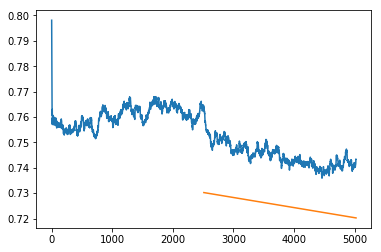

In [45]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(7,slice(3e-5,3e-4),wd=1e-1)

epoch,train_loss,valid_loss,accuracy,map3


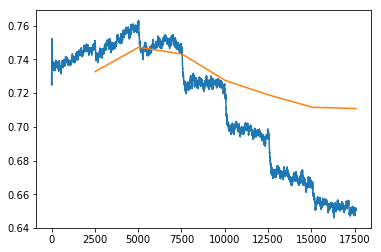

In [47]:
learn.recorder.plot_losses()

In [48]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-3-0312.pth') #overfit

In [18]:
#128
learn.unfreeze()
learn.model.module.load_state_dict(torch.load(f'models/train-2-74loss-96px-color-stage-3-0312.pth'))

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


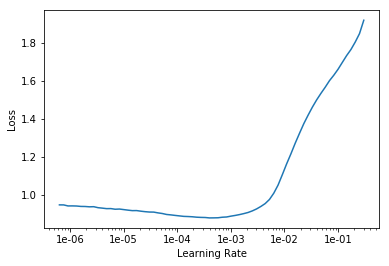

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2,slice(3e-5,3e-4),wd=1e-1)

Total time: 3:27:45
epoch  train_loss  valid_loss  accuracy  map3    
1      0.752892    0.720655    0.810150  0.865996  (1:43:54)
2      0.693920    0.673501    0.822450  0.874942  (1:43:50)



In [23]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-1-0312.pth') #good

In [32]:
learn.fit_one_cycle(2,slice(3e-5,3e-4),wd=1e-1)

Total time: 3:30:21
epoch  train_loss  valid_loss  accuracy  map3    
1      0.729437    0.714834    0.813500  0.868154  (1:44:55)
2      0.667828    0.672264    0.823450  0.875396  (1:45:26)



In [33]:
torch.save(learn.model.module.state_dict(),f'models/{name}-stage-2-0312.pth') 

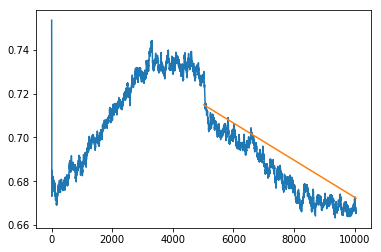

In [34]:
learn.recorder.plot_losses()

In [48]:
learn.model.module.load_state_dict(torch.load(f'models/train-4-67vloss-128px-color-stage-2-0312.pth'))

In [ ]:
learn.fit_one_cycle(1,slice(3e-5/2,3e-4/2))

### Predict

In [53]:
learn = create_cnn(data_bunch, models.resnet50, metrics=[accuracy, map3]).to_fp16()

In [50]:
name = 'testing-train-NA-naloss-128px-color'

In [49]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
create_submission(preds, data_bunch.test_dl, name, data_bunch.y.classes)

In [52]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9300070608292946,finger toe nail
1,9262051680853396,tooth crown mouth
2,9522481627439745,violin guitar cello
3,9655666661258542,waterslide diving_board roller_coaster
4,9765250644373759,cell_phone picture_frame telephone


In [53]:
name

'testing-train-NA-naloss-128px-color'

In [54]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}-2p100-stg2-0312"

100%|██████████████████████████████████████| 1.51M/1.51M [00:01<00:00, 1.18MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

In [ ]:
pred,_ = learn.TTA(with_loss=True)